In [1]:
import pandas as pd
from os import listdir
from pandas.errors import EmptyDataError
from unidecode import unidecode
import seaborn as sns
import re
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

sns.set(
    rc = {
        'figure.figsize': (10, 8)
    },
    style = 'darkgrid'
)

# Dictionaries

In [2]:
grouping_orders = {
    "website": {
        "columns_before": ['website', 'sentiment'],
        "groupby": ["website"],
        "columns_after": ['fakt', 'gazeta', 'wyborcza'] 
    },
    "brand": {
        "columns_before": ['brand', 'sentiment'],
        "groupby": ["brand"],
        "columns_after": ['agora', 'ringier'] 
    },
    "country": {
        "columns_before": ['country', 'sentiment'],
        "groupby": ["country"],
        "columns_after": ['de/ch', 'pl'] 
    }
}

In [3]:
brand_keys = {
    "pl": {
        "agora": ['wyborcza', 'gazeta']
    },
    "de/ch": {
        "ringier": ['fakt']
    }
}

# Read data

## Wyborcza

In [4]:
wyborcza_articles = []
for filename in listdir('data/wyborcza/articles'):
    wyborcza_articles.append(pd.read_csv('data/wyborcza/articles/'+filename, header = None))
wyborcza_articles = pd.concat(wyborcza_articles)
wyborcza_articles.columns = ['url', 'title', 'short', 'long', 'img', 'com']
wyborcza_articles['short'] = wyborcza_articles['short'].str.replace(r'(.|..)\n', '')
wyborcza_articles = wyborcza_articles[~wyborcza_articles['long'].str.contains('W odpowiedzi do @', na = False) == True]
wyborcza_articles['website'] = 'wyborcza'
wyborcza_articles['brand'] = 'agora'
wyborcza_articles['country'] = 'pl'

In [5]:
wyborcza_articles.head(3)

,url,title,short,long,img,com,website,brand,country
1,"https://wyborcza.pl/1,155287,7439653,Zdecydowa...",Zdecydowana większość newsów pochodzi z gazet,Z badań przeprowadzonych przez Pew Research Ce...,Choć rośnie liczba źródeł wiadomości na platfo...,NaN,NaN,wyborcza,agora,pl
2,"https://lodz.wyborcza.pl/lodz/7,35136,23016701...","Gwiazdy na łódzkiej premierze filmu ""Pomiędzy ...",Łódź filmowa doczekała się kolejnej premiery. ...,"""Pomiędzy słowami"" to ostatni film Urszuli An...",MARCIN STĘPIEŃ,NaN,wyborcza,agora,pl
3,"https://wyborcza.pl/1,75399,17168698,Putin_sie...","Putin się zgrał. ""Bracia na wieki"" zza wielkie...",CO DZIŚ W ROSJI PISZCZY? Kiedy nawet bratnie r...,Spełniło się marzenie gospodarzy Kremla. Od la...,Wacław Radziwinowicz,"""a mialo byc tak pieknie... wywiady mialy byc....",wyborcza,agora,pl


## Gazeta

In [6]:
gazeta_articles = []
for filename in listdir('data/gazeta/articles'):
    try:
        gazeta_articles.append(pd.read_csv('data/gazeta/articles/'+filename, header = None))
    except EmptyDataError:
        pass # empty file
gazeta_articles = pd.concat(gazeta_articles)
gazeta_articles.columns = ['url', 'title', 'short', 'long', 'img', 'com']
gazeta_articles['website'] = 'gazeta'
gazeta_articles['brand'] = 'agora'
gazeta_articles['country'] = 'pl'

In [7]:
gazeta_articles.head(3)

,url,title,short,long,img,com,website,brand,country
0,http://metrowarszawa.gazeta.pl/metrowarszawa/7...,Warszawa. Będą dwie nowe stacje na I linii met...,"Ratusz podpisał umowę z firmą Metroprojekt, kt...","""Jak zapowiadałem w kampanii wyborczej pracuje...",Fot. Urząd Miasta Warszawa,"Najpierw powinna powstać III linia, a dopiero ...",gazeta,agora,pl
1,"http://wiadomosci.gazeta.pl/wiadomosci/1,11487...",Prezydent Duda w Paryżu o uchodźcach: Pomagać ...,Wsparcie finansowe dla uchodźców zapowiedział ...,Chcesz wiedzieć szybciej? Polub nas\n- Trzeba ...,Fot. Prezydent.pl,Brawo Duda. Trzeba opieprzyć tych baranów z za...,gazeta,agora,pl
2,"http://podroze.gazeta.pl/podroze/7,114158,2496...","Grecy szukają osób, które zgodziłyby się zamie...","Jeśli kiedykolwiek marzyłeś o tym, aby zamiesz...",Andikitira to grecka wyspa zaliczana do Wysp J...,fot. Shutterstock,Lepsze jest 500€ niż pincetplus.\nJadę!-@@@-Ta...,gazeta,agora,pl


## Add keywords to wyborcza and gazeta

In [8]:
listdir('data/wyborcza_gazeta/urls')

['duda',
 'premier',
 'kwa%B6niewski',
 'imigranci',
 'lgbt',
 'bank',
 'ko%B6ci%F3%B3',
 'rydzyk',
 'feminizm',
 'emigracja',
 'lewica',
 'prezydent',
 'trump',
 'kaczy%F1ski',
 'pis',
 'stany',
 's%B1d+najwy%BFszy',
 'prawica',
 'sejm',
 'szyd%B3o',
 'ukraina',
 'opozycja',
 'polska',
 'leszek+miller',
 'rosja',
 'unia+europejska',
 'platforma',
 'rz%B1d',
 'niemcy',
 'media',
 'morawiecki',
 'putin',
 'papie%BF',
 'korwin',
 'ekologia']

In [9]:
decoder = {
    '%B1': 'ą',
    '%BF': 'ż',
    '%B3': 'ł',
    '%B6': 'ś',
    '%F1': 'ń',
    '%F3': 'ó'
}

In [10]:
keyword_urls = {}
keywords = []
for filename in listdir('data/wyborcza_gazeta/urls'):
    with open('data/wyborcza_gazeta/urls/'+filename, 'r') as f:
        urls = [x for x in f.read().split('\n') if 'gazeta.pl' in x or 'wyborcza.pl' in x]
        for key in decoder.keys():
            filename = filename.replace(key, decoder[key])
        keyword_urls[filename] = urls
        keywords.append(filename)

In [11]:
keywords_df = pd.concat([
    pd.DataFrame(
        pd.Series([1 for x in keyword_urls[key]], name = key, index = keyword_urls[key]),
    ) for key in keyword_urls.keys()  
], axis = 1, sort = False).fillna(0)

In [12]:
len(wyborcza_articles)

18083

In [13]:
wyborcza_articles = pd.merge(
    wyborcza_articles, 
    keywords_df, 
    left_on = 'url', 
    right_on = keywords_df.index
)

In [14]:
len(wyborcza_articles)

17909

In [15]:
len(gazeta_articles)

3780

In [16]:
gazeta_articles = pd.merge(
    gazeta_articles, 
    keywords_df, 
    left_on = 'url', 
    right_on = keywords_df.index
)

In [17]:
len(gazeta_articles)

3738

## Fakt

In [18]:
fakt_articles = []
for filename in listdir('data/fakt/articles'):
    tmp_df = pd.read_csv('data/fakt/articles/'+filename, header = None)
    tmp_df.columns = ['url', 'title', 'short', 'long', 'img', 'com',]
    tmp_df[filename] = 1
    tmp_df[filename] = tmp_df[filename].fillna(0)
    fakt_articles.append(tmp_df)
fakt_articles = pd.concat(fakt_articles, sort = False)
fakt_articles = fakt_articles[~fakt_articles['long'].isna()]
fakt_articles['long'] = fakt_articles.apply(lambda x: x['long'][len(x['short']):], axis = 1)
fakt_articles['website'] = 'fakt'
fakt_articles['country'] = 'de/ch'
fakt_articles['brand'] = 'ringier'

for keyword in keywords:
    if keyword not in fakt_articles.columns:
        fakt_articles[keyword] = 0

In [19]:
fakt_articles.head(3)

,url,title,short,long,img,com,imigranci,emigracja,pis,sąd+najwyższy,...,rosja,unia+europejska,platforma,rząd,niemcy,media,morawiecki,putin,papież,korwin
0,https://www.fakt.pl/wydarzenia/swiat/gwalt-w-r...,Oto gwałciciele z Rimini!,Włoskie media opublikowały zdjęcia z kamer mon...,"Śledczy są pewni, że znajdujący się na zdjęci...",Oto gwałciciele z Rimini!,NaN,1.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,https://www.fakt.pl/wydarzenia/swiat/bitwa-pol...,Krwawa jatka Polaków pod kościołem,Do nocnej rozróby z udziałem naszych rodaków d...,Do bójki z udziałem ok. 30 osób doszło w półn...,Bitwa Polaków na ulicach Londynu,NaN,1.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,https://www.fakt.pl/wydarzenia/swiat/kaliforni...,Kalifornia pozwała Trumpa. Idzie o miliony,Władze Kalifornii pozwały prezydenta USA Donal...,Administracja Donalda Trumpa ustami prokurato...,Donald Trump,NaN,1.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


## Concentrate data

In [20]:
df = pd.concat([
    wyborcza_articles,
    gazeta_articles,
    fakt_articles
], axis = 0, sort = False)

In [21]:
df.sample(3).head(3)

,url,title,short,long,img,com,website,brand,country,duda,...,unia+europejska,platforma,rząd,niemcy,media,morawiecki,putin,papież,korwin,ekologia
11989,"https://plock.wyborcza.pl/plock/7,35681,253052...",Wybory parlamentarne 2019. Sztab wyborczy PiS ...,Obejrzyjcie zdjęcia z niedzielnego wieczoru wy...,"Wybory parlamentarne 2019. Wyniki, wiadomości ...",Wybory parlamentarne 2019. Politycy i sympatyc...,NaN,wyborcza,agora,pl,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2799,"https://olsztyn.wyborcza.pl/olsztyn/1,48726,62...",Na Brzezinach najlepiej znają swojego kandydata,Sąsiad to ważna osoba. Z sąsiadem się mieszka ...,"Chcieliśmy się dowiedzieć, jaką opinię wypraco...",NaN,NaN,wyborcza,agora,pl,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1619,"http://next.gazeta.pl/next/7,151003,23651656,d...",Dobra zmiana dla tysięcy Polaków. Długi szybci...,"W życie weszły zmiany w prawie, które skracają...",Od 9 lipca obowiązuje nowelizacja prawa cywiln...,Fot. Daniel Adamski / Agencja Gazeta,"Ludzie, większość z was popada w paranoję. Prz...",gazeta,agora,pl,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Analyze

## Get emotions data from polish wordnet

In [22]:
# http://plwordnet.pwr.wroc.pl//wordnet/download-wordnet?key=1iflsj&file=4.0
# extract one file (słownik_anotacji_emocjonlanej) to home directory

In [23]:
emotions = pd.read_csv('~/słownik_anotacji_emocjonlanej.csv')[['lemat', 'emocje']].dropna()

In [24]:
emotions.head()

,lemat,emocje
2,abstrakcyjny,wstręt;złość;zaskoczenie
3,abstrakcyjny,wstręt;złość
10,adorator,złość;radość
11,adorator,złość;cieszenie się na;radość;wstręt
18,afektowany,złość;smutek


In [25]:
emotions['emocje'] = emotions['emocje'].str.replace(':', ';')

In [26]:
pairs = [
    ('złosć', 'negatywny'),
    ('zlość', 'negatywny'),
    ('złośc', 'negatywny'),
    ('złość wstręt', 'negatywny'),
    ('złość: nieużyteczność', 'negatywny'),
    ('złóść', 'negatywny'),
    ('bład', 'negatywny'),
    ('brzydota', 'negatywny'),
    ('błąd', 'negatywny'),
    ('gniew', 'negatywny'),
    ('krzywda', 'negatywny'),
    ('nieszczęscie', 'negatywny'),
    ('nieszczęście', 'negatywny'),
    ('nieużyteczność', 'negatywny'),
    ('złość', 'negatywny'),
    ('strach', 'negatywny'),
    ('strach wstręt', 'negatywny'),
    ('smute', 'negatywny'),
    ('smutek', 'negatywny'),
    ('wstęt', 'negatywny'),
    ('niewiedza', 'negatywny'),
    ('negatywny wstręt', 'negatywny'),
    ('negatywnyk', 'negatywny'),
    ('negatywnyk: negatywny', 'negatywny'),
    ('wstrę', 'negatywny'),
    ('wstręt', 'negatywny'),
    ('wstręt: negatywny', 'negatywny'),
    ('negatywnyt', 'negatywny'),
    ('s mutek', 'negatywny'),
    ('wstret', 'negatywny'),
    ('smitek', 'negatywny'),
    (' negatywny', 'negatywny'),
    
    ('cieszenie sie', 'pozytywny'),
    ('cieszenie sie na', 'pozytywny'),
    ('cieszenie się na coś oczekiwanego', 'pozytywny'),
    ('dobro', 'pozytywny'),
    ('cieszenie sie', 'pozytywny'),
    ('radoć', 'pozytywny'),
    ('radość', 'pozytywny'),
    ('radość: piękno', 'pozytywny'),
    ('radość: szczęście', 'pozytywny'),
    ('zaufanie', 'pozytywny'),
    ('cieszenie się', 'pozytywny'),
    ('cieszenie się na', 'pozytywny'),
    ('ciesznie się na', 'pozytywny'),
    ('piękno', 'pozytywny'),
    ('pozytywny: piękno', 'pozytywny'),
    ('pozytywny: szczęście', 'pozytywny'),
    ('prawda', 'pozytywny'),
    ('radosć', 'pozytywny'),
    ('pozytywny: pozytywny', 'pozytywny'),
    ('radośc', 'pozytywny'),
    ('szczęście', 'pozytywny'),
    ('użyteczność', 'pozytywny'),
    ('wiedza', 'pozytywny'),
    ('zufanie', 'pozytywny'),
    ('pozytywny na', 'pozytywny'),
    (' pozytywny', 'pozytywny'),
    
    ('zaskoczenie czymś nieprzewidywanym', ''),
    ('oczekiwanie na', ''),
    (' czymś nieprzewidywanym', ''),
    ('-', ''),
    ('zaskoczenie', ''),
    ('pozytywnynegatywny', ''),
]

In [27]:
for pair in pairs:
    emotions['emocje'] = emotions['emocje'].str.replace(pair[0], pair[1])

In [28]:
emotions = pd.concat([
    emotions['lemat'],
    emotions['emocje']\
        .str.get_dummies(sep = ';')\
], axis = 1)

In [29]:
emotions.loc[
    emotions['pozytywny'] == emotions['negatywny']
, 'ambiguous'] = True

In [30]:
len(emotions)

56420

In [31]:
emotions = emotions[emotions['ambiguous'].isna()]
emotions = emotions.drop('ambiguous', axis = 1)

In [32]:
len(emotions)

47477

In [33]:
emotions['negatywny'].sum()

31505

In [34]:
emotions['pozytywny'].sum()

15972

In [35]:
emotions.sample(5).head()

,lemat,negatywny,pozytywny
107694,nieskwapliwość,0,1
154808,spokojniuchny,0,1
109344,subtelność,0,1
74825,uznaniowy,1,0
155569,kombinacyjnie,0,1


In [36]:
emotions = emotions.drop('negatywny', axis = 1)

In [37]:
emotions.loc[emotions['pozytywny'] == 0, 'pozytywny'] = -1

In [38]:
emotions.columns = ['lemat', 'sentyment']

In [39]:
emotions = emotions.drop_duplicates()

In [40]:
emotions.sample(5).head()

,lemat,sentyment
68449,letargiczny,-1
8470,wytłumaczyć,1
45315,człowiek wielkiego ducha,1
168779,fetyszystyczny,-1
27600,unifikator,1


In [41]:
emotions_dict = {x[0]:x[1] for x in emotions.values}

## Titles/shorts

In [42]:
emotions.sample(5).head()

,lemat,sentyment
161843,pośpieszyć,1
8634,zadra,-1
84046,niezły,1
131006,marzenie ściętej głowy,-1
44288,panienka spod latarni,-1


In [43]:
emotion_words = emotions_dict.keys()

In [44]:
df['sentiment'] = df['long'].str.lower().apply(lambda x: sum([emotions_dict[a] 
                                         for a in str(x).split(' ')
                                         if a in emotion_words]))

In [45]:
grouped_data = {}
for key, grouping_order in grouping_orders.items():
    data_dict = {}
    for keyword in keywords:
        data_dict[keyword] = df\
            [(df[keyword] == 1)&(df['sentiment'] != 0)]\
            [grouping_order['columns_before']]\
            .groupby(grouping_order['groupby'])\
            .mean()\
            .values\
            .flatten()
    res = pd.DataFrame().from_dict(
        data_dict,
        'index',
        columns = grouping_order['columns_after']
    )
    res = (res - res.mean())/res.std()
    grouped_data[key] = res

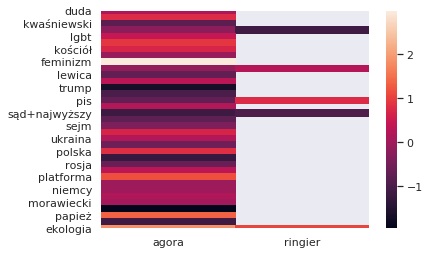

In [46]:
sns.heatmap(grouped_data['brand']);

In [47]:
# compare that chart (two websites in one company), and two websites from two different companies

## Regex

In [48]:
wc = WordCloud()

In [49]:
keyword_patterns = ['duda', 'dudy', 'dude']

In [50]:
found_records = df[['long']][
    df['long'].str.lower().str.contains(r'|'.join(keyword_patterns)) == True
].values.flatten()

In [51]:
keyword_words_before = []
keyword_words_after = []
for record in found_records:
    tmp_string_list = re.sub(r'\W+', ' ', record).lower().split(' ')
    keyword_idxs = [n for n, x in enumerate(tmp_string_list) if x in keyword_patterns]
    max_idx = len(tmp_string_list)
    for keyword_idx in keyword_idxs:
        if keyword_idx < max_idx - 2 and keyword_idx > 1:
            keyword_context_before = tmp_string_list[keyword_idx-2 : keyword_idx]
            keyword_words_before.append(keyword_context_before[0])
            keyword_words_before.append(keyword_context_before[1])
            keyword_context_after = tmp_string_list[keyword_idx+1 : keyword_idx+3]
            keyword_words_after.append(keyword_context_after[0])
            keyword_words_after.append(keyword_context_after[1])

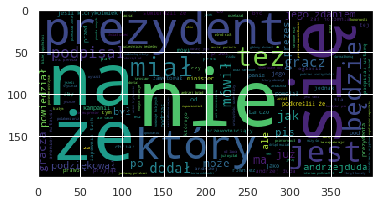

In [52]:
plt.imshow(wc.generate(" ".join(keyword_words_after)))

## Word2Vec

In [53]:
def make_sentences(df):
    sentences = []
    for record in (df['title'].fillna('')+'. '+df['short'].fillna('')+' '+df['long'].fillna('')).str.lower():
        if record != None:
            for sentence in record.split('.'):
                sentences.append(re.sub(r'\W+', ' ', sentence).lower().strip().split(' '))
    return sentences

In [54]:
models = {}
for country, brand_dict in brand_keys.items():
    models[country] = {}
    country_data = make_sentences(df[df['country'] == country])
    models[country]['model'] = Word2Vec(country_data, min_count=10)
    for brand_name, websites in brand_dict.items():
        models[country][brand_name] = {}
        brand_data = make_sentences(df[df['brand'] == brand_name])
        models[country][brand_name]['model'] = Word2Vec(brand_data, min_count=10)
        for website_name in websites:
            models[country][brand_name][website_name] = {}
            website_data = make_sentences(df[df['website'] == website_name])
            models[country][brand_name][website_name]['model'] = Word2Vec(website_data, min_count=10)

In [55]:
models['model'] = Word2Vec(make_sentences(df), min_count=10)

In [56]:
vectors = models['model'].wv.vectors
words = models['model'].wv.vocab

In [ ]:
dim_reduction = TSNE(n_components = 3, n_jobs = 10).fit(vectors)

In [ ]:
sum(dim_reduction.explained_variance_ratio_)*100

In [ ]:
wv.wv.most_similar(positive=['unia'], topn=5)

In [ ]:
wv.wv['duda']

In [ ]:
from sklearn.decomposition import PCA